# ![Keras](https://img.shields.io/badge/Keras-%23D00000.svg?style=for-the-badge&logo=Keras&logoColor=white) **CHAPTER 11 - TRAINING DEEP NEURAL NETWORKS**

---

## **SETUP:**

In [1]:
# %load ../initial_settings.py
"""
Initial settings for data analysis and machine learning.
Use this with: %load ../initial_settings.py
"""

import os
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from packaging import version

# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# And TensorFlow 2.8 or above.
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Graphviz source.
os.environ["PATH"] += os.pathsep + "C:/Programy/Graphviz/bin/"

# Default settings for matplotlib.
DARK_BLUE = "#03002e"
LIGHT_GRAY = "#8f8f99"

plt.rc("font", size=14)
plt.rc("legend", fontsize=14)
plt.rc("text", color=DARK_BLUE)

plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelpad=10)
plt.rc("axes", labelcolor=DARK_BLUE)
plt.rc("axes", grid=True)

plt.rc("xtick", labelsize=12, color=DARK_BLUE)
plt.rc("ytick", labelsize=12, color=DARK_BLUE)
plt.rc("xtick.major", pad=10)
plt.rc("ytick.major", pad=10)

plt.rc("grid", color=LIGHT_GRAY)
plt.rc("grid", linestyle="dashed")
plt.rc("grid", linewidth=0.5)
plt.rc("grid", alpha=0.5)

# Create a directory for matplotlib images.
IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(
    fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"
):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)


---

## **VANISHING/EXPLODING GRADIENTS PROBLEM**

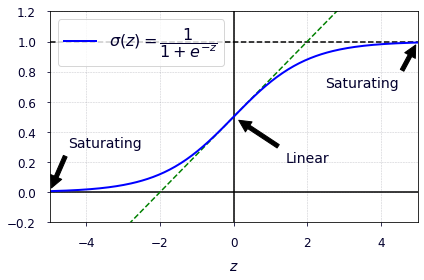

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

### **XAVIER AND HE INITIALIZATION:**

In [2]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

In [3]:
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_avg", distribution="uniform"
)
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)


### **NONSATURATING ACTIVATION FUNCTIONS:**

#### **LEAKY RELU:**

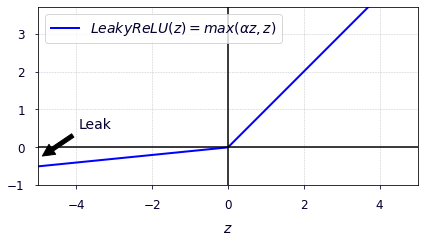

In [5]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [7]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")


In [9]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(50, kernel_initializer="he_normal"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
    ]
)


#### **ELU:**

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [10]:
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")


#### **SELU:**

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

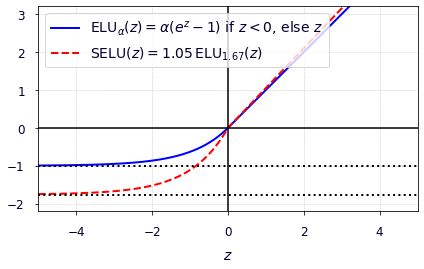

In [11]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [12]:
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")


**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [13]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))


In [14]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)


Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [16]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255


In [17]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


In [19]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds


In [20]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)


Epoch 1/5
1719/1719 [==============================] - 44s 22ms/step - loss: 1.4914 - accuracy: 0.4051 - val_loss: 1.1407 - val_accuracy: 0.5580
Epoch 2/5
1719/1719 [==============================] - 38s 22ms/step - loss: 1.1141 - accuracy: 0.5781 - val_loss: 0.8807 - val_accuracy: 0.6392
Epoch 3/5
1719/1719 [==============================] - 39s 23ms/step - loss: 0.9245 - accuracy: 0.6403 - val_loss: 0.8224 - val_accuracy: 0.6908
Epoch 4/5
1719/1719 [==============================] - 38s 22ms/step - loss: 0.8469 - accuracy: 0.6903 - val_loss: 0.7042 - val_accuracy: 0.7588
Epoch 5/5
1719/1719 [==============================] - 37s 22ms/step - loss: 0.6635 - accuracy: 0.7612 - val_loss: 0.6302 - val_accuracy: 0.7688


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [21]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))


In [22]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)


In [23]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid, y_valid)
)


Epoch 1/5
1719/1719 [==============================] - 42s 23ms/step - loss: 2.1714 - accuracy: 0.1652 - val_loss: 2.0503 - val_accuracy: 0.2014
Epoch 2/5
1719/1719 [==============================] - 39s 23ms/step - loss: 1.7261 - accuracy: 0.3073 - val_loss: 2.1016 - val_accuracy: 0.2152
Epoch 3/5
1719/1719 [==============================] - 39s 23ms/step - loss: 1.2954 - accuracy: 0.4962 - val_loss: 2.7799 - val_accuracy: 0.2282
Epoch 4/5
1719/1719 [==============================] - 37s 22ms/step - loss: 1.1424 - accuracy: 0.5688 - val_loss: 2.2667 - val_accuracy: 0.2166
Epoch 5/5
1719/1719 [==============================] - 37s 22ms/step - loss: 1.2850 - accuracy: 0.5146 - val_loss: 1.9295 - val_accuracy: 0.2774


Not great at all, we suffered from the vanishing/exploding gradients problem.

#### **GELU, SWHISH AND MISH:**

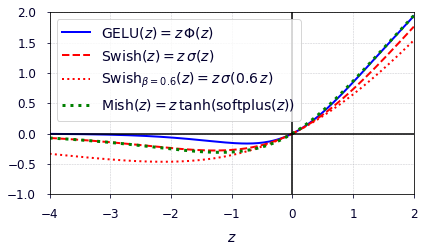

In [24]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

### **BATCH NORMALIZATION:**

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [27]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_3 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_4 (Batc  (None, 100)              4

In [30]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization_2/gamma:0', True),
 ('batch_normalization_2/beta:0', True),
 ('batch_normalization_2/moving_mean:0', False),
 ('batch_normalization_2/moving_variance:0', False)]

In [31]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics="accuracy"
)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 6ms/step - loss: 0.5514 - accuracy: 0.8086 - val_loss: 0.3959 - val_accuracy: 0.8520
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4045 - accuracy: 0.8554 - val_loss: 0.3633 - val_accuracy: 0.8658


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [33]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)


In [35]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics="accuracy"
)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6060 - accuracy: 0.7975 - val_loss: 0.4266 - val_accuracy: 0.8464
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4238 - accuracy: 0.8513 - val_loss: 0.3741 - val_accuracy: 0.8652


### **GRADIENT CLIPPING:**

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [36]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [37]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

### **REUSING PRETRAINED LAYERS:**

#### **REUSING A KERAS MODEL:**

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [38]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("models/my_model_A")

Epoch 1/20
1376/1376 [==============================] - 5s 3ms/step - loss: 1.1577 - accuracy: 0.6503 - val_loss: 0.6905 - val_accuracy: 0.7779
Epoch 2/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.5969 - accuracy: 0.8053 - val_loss: 0.5126 - val_accuracy: 0.8295
Epoch 3/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4786 - accuracy: 0.8476 - val_loss: 0.4370 - val_accuracy: 0.8551
Epoch 4/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.4179 - accuracy: 0.8645 - val_loss: 0.3926 - val_accuracy: 0.8716
Epoch 5/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3807 - accuracy: 0.8761 - val_loss: 0.3665 - val_accuracy: 0.8752
Epoch 6/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3546 - accuracy: 0.8834 - val_loss: 0.3456 - val_accuracy: 0.8817
Epoch 7/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3358 - accuracy: 0.8873 - val_loss: 0.3295 - val_accuracy:

In [39]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model_B.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model_B.fit(
    X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B)
)
model_B.evaluate(X_test_B, y_test_B)


Epoch 1/20
7/7 [==============================] - 1s 46ms/step - loss: 0.8709 - accuracy: 0.4450 - val_loss: 0.8098 - val_accuracy: 0.4827
Epoch 2/20
7/7 [==============================] - 0s 24ms/step - loss: 0.8083 - accuracy: 0.4450 - val_loss: 0.7620 - val_accuracy: 0.4827
Epoch 3/20
7/7 [==============================] - 0s 22ms/step - loss: 0.7585 - accuracy: 0.4450 - val_loss: 0.7210 - val_accuracy: 0.4827
Epoch 4/20
7/7 [==============================] - 0s 22ms/step - loss: 0.7152 - accuracy: 0.4450 - val_loss: 0.6900 - val_accuracy: 0.4847
Epoch 5/20
7/7 [==============================] - 0s 26ms/step - loss: 0.6828 - accuracy: 0.4450 - val_loss: 0.6611 - val_accuracy: 0.5134
Epoch 6/20
7/7 [==============================] - 0s 26ms/step - loss: 0.6524 - accuracy: 0.5450 - val_loss: 0.6361 - val_accuracy: 0.5816
Epoch 7/20
7/7 [==============================] - 0s 23ms/step - loss: 0.6256 - accuracy: 0.6250 - val_loss: 0.6136 - val_accuracy: 0.6657
Epoch 8/20
7/7 [===========

[0.4313914179801941, 0.9144999980926514]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [40]:
model_A = tf.keras.models.load_model("models/my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [41]:
tf.random.set_seed(42)

In [42]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [44]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [45]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)


In [55]:
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B)
)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B),
)


Epoch 1/4
7/7 [==============================] - 0s 33ms/step - loss: 0.1048 - accuracy: 0.9700 - val_loss: 0.1609 - val_accuracy: 0.9456
Epoch 2/4
7/7 [==============================] - 0s 26ms/step - loss: 0.1044 - accuracy: 0.9700 - val_loss: 0.1609 - val_accuracy: 0.9446
Epoch 3/4
7/7 [==============================] - 0s 28ms/step - loss: 0.1039 - accuracy: 0.9700 - val_loss: 0.1608 - val_accuracy: 0.9446
Epoch 4/4
7/7 [==============================] - 0s 25ms/step - loss: 0.1036 - accuracy: 0.9700 - val_loss: 0.1609 - val_accuracy: 0.9466
Epoch 1/16
7/7 [==============================] - 1s 61ms/step - loss: 0.1029 - accuracy: 0.9700 - val_loss: 0.1610 - val_accuracy: 0.9466
Epoch 2/16
7/7 [==============================] - 0s 30ms/step - loss: 0.1034 - accuracy: 0.9700 - val_loss: 0.1609 - val_accuracy: 0.9466
Epoch 3/16
7/7 [==============================] - 0s 29ms/step - loss: 0.1028 - accuracy: 0.9700 - val_loss: 0.1605 - val_accuracy: 0.9466
Epoch 4/16
7/7 [===============

In [59]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.1744 - accuracy: 0.9390


[0.17436832189559937, 0.9390000104904175]

---

## **FASTER OPTIMIZERS:**

In [60]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[28, 28]),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )


def build_and_train_model(optimizer):
    model = build_model()
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    return model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


### **SGD:**

In [63]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3753 - accuracy: 0.5861 - val_loss: 0.8552 - val_accuracy: 0.7312
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7516 - accuracy: 0.7542 - val_loss: 0.6593 - val_accuracy: 0.7780
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6316 - accuracy: 0.7874 - val_loss: 0.5842 - val_accuracy: 0.8012
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5756 - accuracy: 0.8054 - val_loss: 0.5451 - val_accuracy: 0.8154
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5412 - accuracy: 0.8154 - val_loss: 0.5222 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5171 - accuracy: 0.8226 - val_loss: 0.5106 - val_accuracy: 0.8180
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4990 - accuracy: 0.8273 - val_loss: 0.4869 - val_accuracy:

### **MOMENTUM OPTIMIZATION:**

In [72]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history_momentum = build_and_train_model(optimizer)


Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6991 - accuracy: 0.7576 - val_loss: 0.5179 - val_accuracy: 0.8124
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4700 - accuracy: 0.8339 - val_loss: 0.4500 - val_accuracy: 0.8364
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4238 - accuracy: 0.8500 - val_loss: 0.4145 - val_accuracy: 0.8532
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3971 - accuracy: 0.8603 - val_loss: 0.3853 - val_accuracy: 0.8560
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3766 - accuracy: 0.8669 - val_loss: 0.3708 - val_accuracy: 0.8658
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3632 - accuracy: 0.8709 - val_loss: 0.3691 - val_accuracy: 0.8666
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3464 - accuracy: 0.8753 - val_loss: 0.3704 - val_accuracy:

### **NESTEROV ACCELERATED GRADIENT:**

In [64]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6782 - accuracy: 0.7680 - val_loss: 0.4884 - val_accuracy: 0.8338
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4563 - accuracy: 0.8411 - val_loss: 0.4376 - val_accuracy: 0.8394
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4138 - accuracy: 0.8549 - val_loss: 0.4028 - val_accuracy: 0.8576
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3884 - accuracy: 0.8640 - val_loss: 0.3805 - val_accuracy: 0.8648
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3683 - accuracy: 0.8696 - val_loss: 0.3701 - val_accuracy: 0.8680
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3535 - accuracy: 0.8744 - val_loss: 0.3781 - val_accuracy: 0.8664
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3400 - accuracy: 0.8792 - val_loss: 0.3785 - val_accuracy:

### **ADAGRAD:**

In [65]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0354 - accuracy: 0.6694 - val_loss: 0.7049 - val_accuracy: 0.7756
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6585 - accuracy: 0.7859 - val_loss: 0.5974 - val_accuracy: 0.8012
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5834 - accuracy: 0.8081 - val_loss: 0.5471 - val_accuracy: 0.8192
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5424 - accuracy: 0.8203 - val_loss: 0.5165 - val_accuracy: 0.8274
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5157 - accuracy: 0.8277 - val_loss: 0.4958 - val_accuracy: 0.8316
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4970 - accuracy: 0.8333 - val_loss: 0.4826 - val_accuracy: 0.8322
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4831 - accuracy: 0.8369 - val_loss: 0.4705 - val_accuracy:

### **RMSPROP:**

In [66]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.5161 - accuracy: 0.8129 - val_loss: 0.3927 - val_accuracy: 0.8542
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3961 - accuracy: 0.8589 - val_loss: 0.4198 - val_accuracy: 0.8462
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3713 - accuracy: 0.8680 - val_loss: 0.3901 - val_accuracy: 0.8700
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3636 - accuracy: 0.8754 - val_loss: 0.3737 - val_accuracy: 0.8742
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3607 - accuracy: 0.8768 - val_loss: 0.3906 - val_accuracy: 0.8698
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3546 - accuracy: 0.8773 - val_loss: 0.4294 - val_accuracy: 0.8668
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3543 - accuracy: 0.8785 - val_loss: 0.4784 - val_accuracy

### **ADAM:**

In [67]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adam = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4995 - accuracy: 0.8220 - val_loss: 0.4372 - val_accuracy: 0.8342
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3777 - accuracy: 0.8617 - val_loss: 0.3672 - val_accuracy: 0.8600
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3446 - accuracy: 0.8730 - val_loss: 0.3450 - val_accuracy: 0.8680
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3190 - accuracy: 0.8827 - val_loss: 0.3498 - val_accuracy: 0.8736
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3008 - accuracy: 0.8875 - val_loss: 0.3314 - val_accuracy: 0.8794
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2861 - accuracy: 0.8939 - val_loss: 0.3677 - val_accuracy: 0.8734
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2740 - accuracy: 0.8963 - val_loss: 0.3484 - val_accuracy:

### **ADAMAX:**

In [68]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamax = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5364 - accuracy: 0.8137 - val_loss: 0.4331 - val_accuracy: 0.8392
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3995 - accuracy: 0.8571 - val_loss: 0.3880 - val_accuracy: 0.8568
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3623 - accuracy: 0.8683 - val_loss: 0.3750 - val_accuracy: 0.8658
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3360 - accuracy: 0.8779 - val_loss: 0.3448 - val_accuracy: 0.8728
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3150 - accuracy: 0.8839 - val_loss: 0.3294 - val_accuracy: 0.8796
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2995 - accuracy: 0.8912 - val_loss: 0.3375 - val_accuracy: 0.8764
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2862 - accuracy: 0.8942 - val_loss: 0.3302 - val_accuracy:

### **NADAM:**

In [69]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_nadam = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4831 - accuracy: 0.8251 - val_loss: 0.4030 - val_accuracy: 0.8472
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3624 - accuracy: 0.8668 - val_loss: 0.3559 - val_accuracy: 0.8686
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3260 - accuracy: 0.8797 - val_loss: 0.3481 - val_accuracy: 0.8726
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3061 - accuracy: 0.8873 - val_loss: 0.3295 - val_accuracy: 0.8760
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2899 - accuracy: 0.8917 - val_loss: 0.3301 - val_accuracy: 0.8752
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2734 - accuracy: 0.8987 - val_loss: 0.3716 - val_accuracy: 0.8702
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2647 - accuracy: 0.9001 - val_loss: 0.3384 - val_ac

### **ADAMW:**

In [70]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(
    weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999
)
history_adamw = build_and_train_model(optimizer)


Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4961 - accuracy: 0.8233 - val_loss: 0.4208 - val_accuracy: 0.8346
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3733 - accuracy: 0.8632 - val_loss: 0.3936 - val_accuracy: 0.8458
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3386 - accuracy: 0.8754 - val_loss: 0.3520 - val_accuracy: 0.8730
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3148 - accuracy: 0.8836 - val_loss: 0.3517 - val_accuracy: 0.8684
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2968 - accuracy: 0.8905 - val_loss: 0.3274 - val_accuracy: 0.8740
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2845 - accuracy: 0.8947 - val_loss: 0.3433 - val_accuracy: 0.8704
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2737 - accuracy: 0.8967 - val_loss: 0.3387 - val_accuracy:

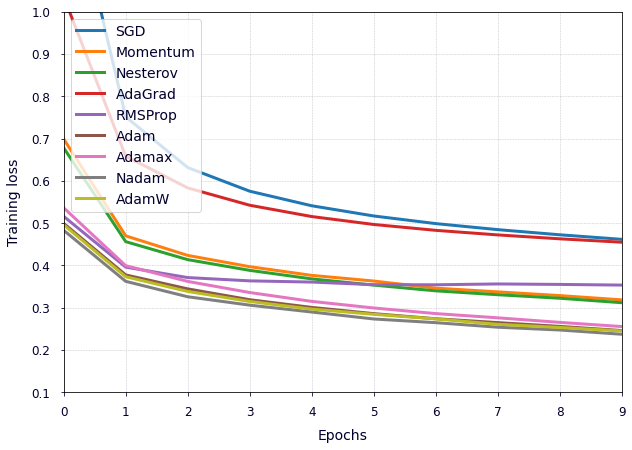

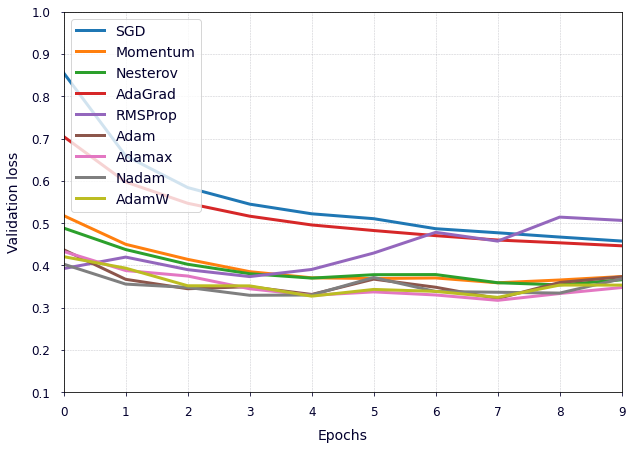

In [80]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(10, 7))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip(
        (
            history_sgd,
            history_momentum,
            history_nesterov,
            history_adagrad,
            history_rmsprop,
            history_adam,
            history_adamax,
            history_nadam,
            history_adamw,
        ),
        opt_names.split(),
    ):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    #plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 1.0])
    plt.show()


---

## **LEARNING RATE SCHEDULING:**

### **POWER SCHEDULING:**

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [81]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6902 - accuracy: 0.7672 - val_loss: 0.4911 - val_accuracy: 0.8272
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4698 - accuracy: 0.8350 - val_loss: 0.4431 - val_accuracy: 0.8364
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4257 - accuracy: 0.8487 - val_loss: 0.4152 - val_accuracy: 0.8538
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4036 - accuracy: 0.8582 - val_loss: 0.3966 - val_accuracy: 0.8590
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3858 - accuracy: 0.8634 - val_loss: 0.3861 - val_accuracy: 0.8624
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3716 - accuracy: 0.8685 - val_loss: 0.3910 - val_accuracy: 0.8630
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3622 - accuracy: 0.8718 - val_loss: 0.3749 - val_accuracy:

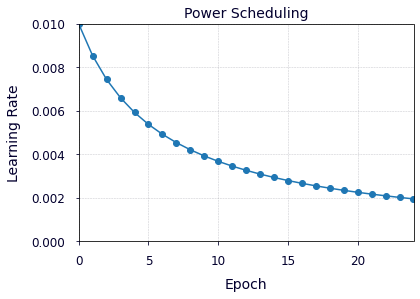

In [94]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.show()

### **EXPONENTIAL SCHEDULING:**

```lr = lr0 * 0.1 ** (epoch / s)```

In [95]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)


In [104]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.01, s=20)


In [105]:
tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)


In [106]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)


Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6723 - accuracy: 0.7712 - val_loss: 0.4952 - val_accuracy: 0.8268 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4646 - accuracy: 0.8361 - val_loss: 0.4579 - val_accuracy: 0.8350 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4196 - accuracy: 0.8518 - val_loss: 0.4143 - val_accuracy: 0.8552 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3960 - accuracy: 0.8603 - val_loss: 0.3834 - val_accuracy: 0.8634 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3770 - accuracy: 0.8670 - val_loss: 0.3775 - val_accuracy: 0.8624 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3623 - accuracy: 0.8712 - val_loss: 0.3814 - val_accuracy: 0.8600 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 6s

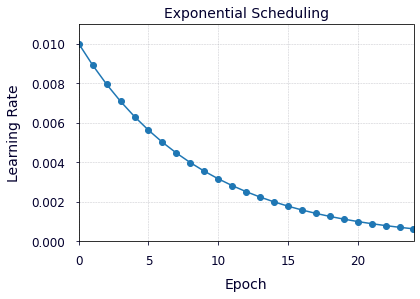

In [107]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [108]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [109]:
K = tf.keras.backend


class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.learning_rate)


In [110]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)


In [111]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[exp_decay],
)


Epoch 1/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6932 - accuracy: 0.7649 - val_loss: 0.4879 - val_accuracy: 0.8272 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4725 - accuracy: 0.8341 - val_loss: 0.4516 - val_accuracy: 0.8350 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4277 - accuracy: 0.8478 - val_loss: 0.4126 - val_accuracy: 0.8526 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4041 - accuracy: 0.8581 - val_loss: 0.3964 - val_accuracy: 0.8582 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3844 - accuracy: 0.8643 - val_loss: 0.3881 - val_accuracy: 0.8624 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3692 - accuracy: 0.8701 - val_loss: 0.3872 - val_accuracy: 0.8632 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================] - 7s

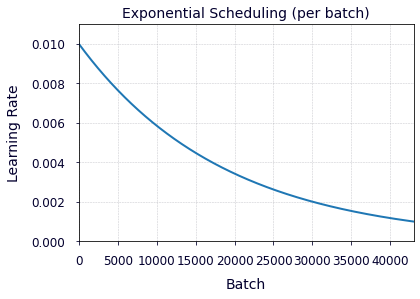

In [112]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.show()

### **PIECEWISE CONSTANT SCHEDULING:**

In [113]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [119]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.


def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)

    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]

    return piecewise_constant_fn


piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [120]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)


Epoch 1/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5765 - accuracy: 0.7940 - val_loss: 0.4597 - val_accuracy: 0.8358 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4588 - accuracy: 0.8397 - val_loss: 0.4643 - val_accuracy: 0.8266 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4333 - accuracy: 0.8474 - val_loss: 0.5097 - val_accuracy: 0.8396 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4148 - accuracy: 0.8558 - val_loss: 0.4107 - val_accuracy: 0.8562 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4011 - accuracy: 0.8590 - val_loss: 0.4695 - val_accuracy: 0.8452 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3628 - accuracy: 0.8703 - val_loss: 0.3929 - val_accuracy: 0.8648 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

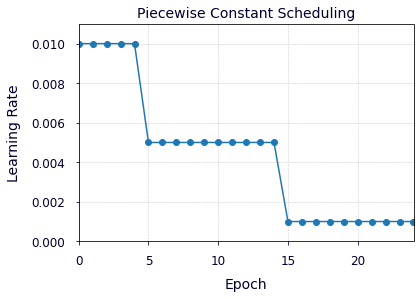

In [123]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.show()

### **PERFORMANCE SCHEDULING:**

In [124]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)


In [125]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler],
)


Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6889 - accuracy: 0.7627 - val_loss: 0.4932 - val_accuracy: 0.8244 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4710 - accuracy: 0.8333 - val_loss: 0.4441 - val_accuracy: 0.8384 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4232 - accuracy: 0.8489 - val_loss: 0.4105 - val_accuracy: 0.8558 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3969 - accuracy: 0.8588 - val_loss: 0.3930 - val_accuracy: 0.8636 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3759 - accuracy: 0.8661 - val_loss: 0.3771 - val_accuracy: 0.8640 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3584 - accuracy: 0.8726 - val_loss: 0.3835 - val_accuracy: 0.8682 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 5s

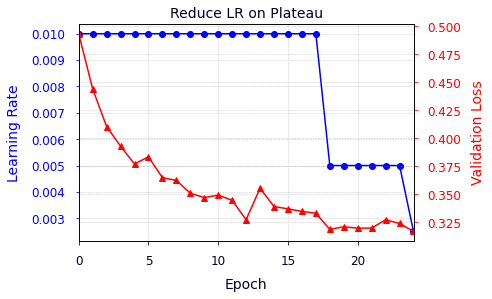

In [126]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### **TF.KERAS SCHEDULRES:**

In [127]:
batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)

scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1
)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)
model = build_and_train_model(optimizer)


Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6966 - accuracy: 0.7608 - val_loss: 0.4855 - val_accuracy: 0.8258
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4697 - accuracy: 0.8340 - val_loss: 0.4506 - val_accuracy: 0.8330
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4219 - accuracy: 0.8505 - val_loss: 0.4184 - val_accuracy: 0.8488
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3974 - accuracy: 0.8598 - val_loss: 0.3859 - val_accuracy: 0.8586
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3771 - accuracy: 0.8662 - val_loss: 0.3820 - val_accuracy: 0.8606
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3617 - accuracy: 0.8709 - val_loss: 0.3867 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3513 - accuracy: 0.8747 - val_loss: 0.3726 - val_accuracy:

### **1CYCLE SCHEDULING:**

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [128]:
K = tf.keras.backend


class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(
            self.model.optimizer.learning_rate,
            self.model.optimizer.learning_rate * self.factor,
        )


The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [133]:
def find_learning_rate(
    model, X, y, epochs=1, batch_size=32, min_rate=1e-4, max_rate=1.0
):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)

    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])

    # Restore initial model.
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)

    return exp_lr.rates, exp_lr.losses


The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [134]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")


Let's build a simple Fashion MNIST model and compile it:

In [143]:
model = build_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)


Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 2s 5ms/step - loss: 1.8687 - accuracy: 0.3597


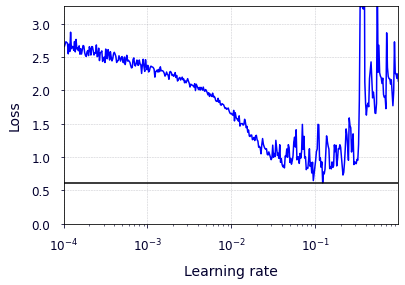

In [145]:
batch_size = 128
rates, losses = find_learning_rate(
    model, X_train, y_train, epochs=1, batch_size=batch_size
)
plot_lr_vs_loss(rates, losses)


Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [137]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(
        self, iterations, max_lr=1e-3, start_lr=None, last_iterations=None, last_lr=None
    ):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr, self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(
                self.half_iteration, 2 * self.half_iteration, self.max_lr, self.start_lr
            )
        else:
            lr = self._interpolate(
                2 * self.half_iteration, self.iterations, self.start_lr, self.last_lr
            )
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)


In [146]:
model = build_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(),
    metrics=["accuracy"],
)
n_epochs = 25
onecycle = OneCycleScheduler(
    math.ceil(len(X_train) / batch_size) * n_epochs, max_lr=0.1
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[onecycle],
)


Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 1.0034 - accuracy: 0.6747 - val_loss: 0.6027 - val_accuracy: 0.7994
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.5725 - accuracy: 0.7998 - val_loss: 0.4939 - val_accuracy: 0.8296
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4992 - accuracy: 0.8219 - val_loss: 0.4675 - val_accuracy: 0.8364
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4509 - accuracy: 0.8381 - val_loss: 0.4343 - val_accuracy: 0.8462
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4221 - accuracy: 0.8480 - val_loss: 0.4067 - val_accuracy: 0.8484
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3973 - accuracy: 0.8568 - val_loss: 0.4954 - val_accuracy: 0.8206
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3817 - accuracy: 0.8622 - val_loss: 0.3998 - val_accuracy: 0.8526
Epoch 

---

## **AVOIDING OVERFITTING THROUGH REGULARIZATION:**

### **$\ell_1$ AND $\ell_2$ REGULARIZATION**

In [147]:
layer = tf.keras.layers.Dense(
    100,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
)


Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [148]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [149]:
from functools import partial

RegularizedDense = partial(
    tf.keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        RegularizedDense(100),
        RegularizedDense(100),
        RegularizedDense(10, activation="softmax"),
    ]
)


In [150]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))


Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.1209 - accuracy: 0.7741 - val_loss: 1.8607 - val_accuracy: 0.8228
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.4262 - accuracy: 0.8147 - val_loss: 1.1270 - val_accuracy: 0.8170


### **DROPOUT:**

In [151]:
tf.random.set_seed(42)

In [152]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)


In [156]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3648 - accuracy: 0.8636 - val_loss: 0.3341 - val_accuracy: 0.8746
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3591 - accuracy: 0.8659 - val_loss: 0.3412 - val_accuracy: 0.8700
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3589 - accuracy: 0.8679 - val_loss: 0.3332 - val_accuracy: 0.8758
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3605 - accuracy: 0.8663 - val_loss: 0.3268 - val_accuracy: 0.8814
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3573 - accuracy: 0.8660 - val_loss: 0.3363 - val_accuracy: 0.8746
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3579 - accuracy: 0.8658 - val_loss: 0.3257 - val_accuracy: 0.8794
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3517 - accuracy: 0.8693 - val_loss: 0.3285 - val_accuracy:

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [157]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.2785 - accuracy: 0.8957


[0.27848488092422485, 0.8956727385520935]

In [158]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3461 - accuracy: 0.8721


[0.3460988402366638, 0.8720999956130981]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

### **MCDROPOUT:**

In [159]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [162]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)


In [201]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 21ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.006, 0.   , 0.076, 0.   ,
        0.919]], dtype=float32)

In [202]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.038, 0.   , 0.139, 0.   ,
       0.822], dtype=float32)

In [203]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.002, 0.001, 0.   , 0.   , 0.081, 0.001, 0.157, 0.   ,
       0.167], dtype=float32)

In [204]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8743

In [206]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [207]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential(
    [
        MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
        for layer in model.layers
    ]
)
mc_model.set_weights(model.get_weights())


In [208]:
mc_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_117 (Dense)           (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_118 (Dense)           (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_119 (Dense)           (None, 10)              

Now we can use the model with MC Dropout:

In [209]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1]) for sample in range(100)], axis=0).round(2)


1/1 [==============================] - 0s 19ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.12, 0.  , 0.85]],
      dtype=float32)

### **MAX NORM:**

In [210]:
dense = tf.keras.layers.Dense(
    100,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.0),
)


In [211]:
MaxNormDense = partial(
    tf.keras.layers.Dense,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.0),
)

tf.random.set_seed(42)
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        MaxNormDense(100),
        MaxNormDense(100),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5501 - accuracy: 0.8028 - val_loss: 0.4536 - val_accuracy: 0.8234
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4097 - accuracy: 0.8504 - val_loss: 0.4135 - val_accuracy: 0.8418
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3775 - accuracy: 0.8615 - val_loss: 0.3712 - val_accuracy: 0.8620
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3604 - accuracy: 0.8681 - val_loss: 0.3591 - val_accuracy: 0.8712
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3457 - accuracy: 0.8715 - val_loss: 0.3512 - val_accuracy: 0.8706
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3377 - accuracy: 0.8745 - val_loss: 0.3721 - val_accuracy: 0.8680
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3276 - accuracy: 0.8778 - val_loss: 0.4037 - val_accuracy: